###  Imports

In [1]:
import numpy as np
import random
#from IPython.display import clear_output
import gym
from gym import Env
from gym.spaces import Discrete
import random
import matplotlib.pyplot as plt
import math
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd

using gpu 4


In [2]:
device = "cuda" if not torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


### Move maken

In [3]:
def legal_move(x,y,z,veld,size):
    #later pad heen

    #max hoogte
    if z > size[2] - 1:
        #print('Max hoogte overstreden, zet de container ergens anders neer')
        return False 
    
    #buiten lot
    if x < 0 or x >= size[0] or y < 0 or y >= size[1]:
        #print("Container staat niet in het lot")
        return False 
    
    #staat al een container
    if veld[x][y][z] != 0:
        #print("Er staat al een container")
        return False
    
    #container zweeft niet
    if not veld[x][y][:z].all() != '0':
        #print("Container zweeft")
        return False 
    
    #container in het midden 
    if y-1 != -1 and y+1 != size[1]:
        if veld[x][y-1][0] != '0' and veld[x][y+1][0] != '0':
            #print("Container staat in het midden")
            return False 
    
    return True  

In [39]:
def action_number_to_xyz(action,size,aarbei):
#    if aarbei == 1:
#        waarde = action + 1
#    else:
#        waarde = action
    waarde = action + 1
    
    if waarde <= 0:
        print("nul")
        print(waarde)
    if waarde > 9:
        print("negen")
        print(waarde)
    for a in range(size[0] + 1):
        if waarde <= a * (size[1] * size[2]):
            x = a - 1
            break 

    waarde_y = waarde - (x * size[1] * size[2])

    for i in range(waarde_y + 1):
        if waarde_y <= i * (size[2]):
            y = i - 1
            break

    z = waarde_y - y * size[2] - 1
    if x < 0:
        print((x,y,z),action, aarbei)
    return x,y,z

In [5]:
def place_container(action, prio, speelveld,size,aarbei):

    x,y,z = action_number_to_xyz(action,size,aarbei)
    
    if legal_move(x,y,z,speelveld,size):
        speelveld[x][y][z] = prio
        return True, speelveld
    else:
        #print("--------Mag niet--------")
        return False, speelveld

### Neuraal netwerk

In [169]:
class Environment():

    def __init__(self,size):
        self.size = size
        self.action_space = Discrete(int(self.size[0]*self.size[1]*self.size[2]))
        self.observation_space = speelveld.flatten()
        self.state = self.reset()
        self.poging = 0

    def step(self,action,prio,aarbei):
        
        if type(self.state) == tuple:
            self.state = self.state[1]
        
        iets = place_container(action,prio,self.state.reshape(self.size),self.size,aarbei)
        
        if iets[0]:
            reward = 8
            self.poging = 0
            
        else:
            reward = -1
            self.poging += 1
            
        self.state = iets[1].flatten()
        return self.state.astype(int), reward, self.state

    def reset(self):
        self.state = np.array([([( [[0] * self.size[2]]) * self.size[1] ]) * self.size[0] ]).astype(object).flatten()
        self.reward = 0
        self.poging = 0
        return self.reward, self.state

    def game_over(self):
        
        #print(self.state)
        #alle containers geplaatst of niet mogelijk container plaatsen 
        aantal_nul = (self.state == 0).sum()

        if aantal_nul == 0 or self.poging >= int(self.size[0]*self.size[1]*self.size[2]) or self.poging >= aantal_nul:
            return True
        return False
    
    def state_(self):
        return self.state
    def action_state_(self):
        return self.action_space
    
    #allowed_states toevoegen?

In [154]:
class myAgent():
    def __init__(self, env, epsilon, min_epsilon):
        self.total_rewards = 0
        self.env = env
        self.epsilon = epsilon
       #state, reward self.state_history = [(0,0),0]
        self.state_history = []
    def steps(self,action,aarbei):   
        
        
 #       if np.random.random() < self.epsilon:
 #            #random actie kiezen
 #           curr_action = env.action_state_().sample()  
        
  #      else: 
            
#             ###################
        #    print("neurale netwerk")
            #curr_action = env.action_state_().sample()  
            
#             ########################

        actie = self.env.step(action , 1,aarbei)  
        
        #reward krijgen 
        self.total_rewards += actie[1]
        return actie
    
    def reset(self):
        self.total_rewards = 0
        return self.total_rewards
    
    def update_history(self, state, reward):
        self.state_history.append((state, reward))
    
    def game_reward(self):
        return self.total_rewards
    
    def learn(self):
        
        #################
        target = size[0]*size[1]*size[2] *4
        ############
        if self.epsilon > min_epsilon + 0.1:
            self.epsilon -= 0.01 #10e-5
        
        return self.epsilon
        

In [173]:
# https://rubikscode.net/2021/07/13/deep-q-learning-with-python-and-tensorflow-2-0/

#niet aanpassen
alpha = 0.1
#
#gamma = 0.6
gamma = 0.1
epsilon = 1
min_epsilon = 0.1
epsilon_afnemen = 0.15
wanneer_epsilon = 100
size =(3,3,1)
epsilon_ja = False

containers = size[0]*size[1]*size[2]
speelveld = np.array([([( [[0] * size[2]]) * size[1] ]) * size[0] ]).astype(object)
enviroment = Environment(size)
#enviroment.reset()
game_scores = []

#q_table = np.zeros([len(enviroment.observation_space)+1, containers], dtype=int)
q_table = np.zeros([containers, containers], dtype=int)
num_of_episodes = 10000

agent = myAgent(enviroment,epsilon,min_epsilon)
enviroment.reset()
reward_game = 0

for episode in range(0, num_of_episodes):
    # Reset the enviroment
    state = enviroment.reset()[1]

    # Initialize variables
    reward = 0
    terminated = False
    agent.reset()
    
    
    
    while not enviroment.game_over():
        state = state.astype(int)
        # Take learned path or explore new actions based on the epsilon
        if random.uniform(0, 1) < epsilon:
            action = enviroment.action_space.sample()
            aarbei = 1
        else:

            action = np.argmax(q_table[state])
            #if action > 9:
            #    print("----")
            #    action = action % 9
            #print(action)
            #print("q")
            aarbei = 2
        
        # Take action   
        next_state, reward, iets = agent.steps(action, aarbei)
        
        # Recalculate
        q_value = q_table[state, action]
        max_value = np.max(q_table[next_state])
        new_q_value = (1 - alpha) * q_value + alpha * (reward + gamma * max_value)
        # Update Q-table
        q_table[state, action] = new_q_value
        state = next_state
    game_rewards = agent.game_reward()
    #print(agent.game_reward())
    #print('Game:{} Score:{}'.format(episode, agent.game_reward()))
    game_scores.append(game_rewards)
    
    if episode % (num_of_episodes//10) == 0:
        print(episode)
    
    if epsilon_ja == False:
        if episode % (wanneer_epsilon) == 0:
            if (epsilon - epsilon_afnemen) >= min_epsilon:
                epsilon= epsilon - epsilon_afnemen
        else:
            epsilon_ja == True 
    
    
print("**********************************")
print("Training is done!\n")
print(max(game_scores),min(game_scores))

0
100000
200000
300000
400000
500000
600000
700000
800000
900000
**********************************
Training is done!

45 -5


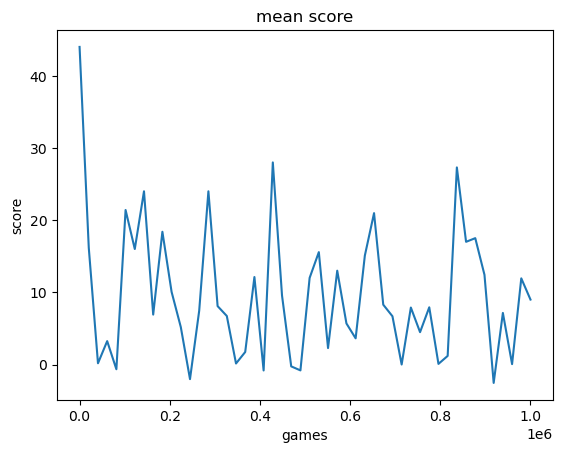

In [174]:
import numpy as np
import numpy as np
from scipy.interpolate import make_interp_spline
import matplotlib.pyplot as plt

#for a in range(int(len(game_scores)/50)):
#    mi = a*50
#    ma = (a+1)*50
#    maxx.append(max([i for i in game_scores[mi:ma] ]))

y = game_scores
x = [i for i in range(num_of_episodes)]
#z = maxx
X_Y_Spline = make_interp_spline(x, y)
#X_z_Spline = make_interp_spline(x, z)

X_ = np.linspace(min(x), max(x), 50)
Y_ = X_Y_Spline(X_)
#Z_ = X_z_Spline(X_)


#print(maxx)
    
#maxx= [max(i) for i in [a for a in ]]
plt.plot(X_, Y_,label = "mean")
#plt.plot(X_, Z_,label = "max")
plt.title("mean score")
plt.xlabel("games")
plt.ylabel("score")
plt.show()

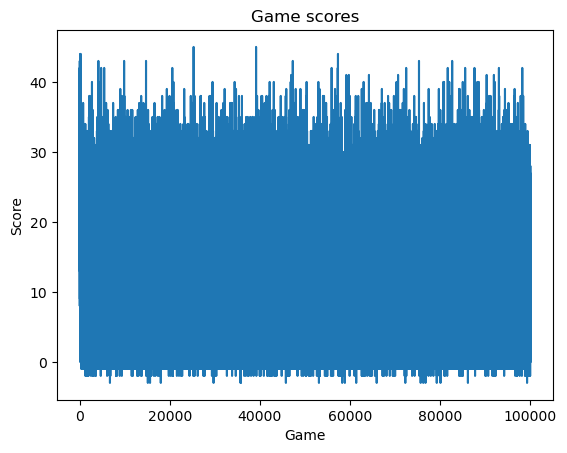

In [172]:
#plt.scatter
plt.plot(range(num_of_episodes),game_scores, linestyle='solid')
plt.title("Game scores")
plt.xlabel("Game")
plt.ylabel("Score")
#plt.axis(range(games)/4)
plt.show()

In [ ]:
#https://pythonprogramming.net/training-deep-learning-neural-network-pytorch/?completed=/building-deep-learning-neural-network-pytorch/

In [ ]:
#https://towardsdatascience.com/hands-on-introduction-to-reinforcement-learning-in-python-da07f7aaca88

In [ ]:
#https://towardsdatascience.com/understanding-actor-critic-methods-931b97b6df3f

### Container data

In [ ]:
aantal_containers = 9
prio = ['H', 'L']
container_id = []
container_prio = []

for c in range(aantal_containers):
    container_id.append(c)
    container_prio_index = random.randrange(len(prio))
    container_prio.append(prio[container_prio_index])

container_data = np.column_stack((container_id,container_prio))

## oud

### Speelbord

In [ ]:
#container op (1,2,0) = speelveld[0][1][1][1]
size = (3,3,2)
speelveld = np.array([([( [['0'] * size[2]]) * size[1] ]) * size[0] ]).astype(object)


### Random invullen

In [ ]:
#werkt niet meer!
size = (3,3,2)
speelveld = np.array([([( [['0'] * size[2]]) * size[1] ]) * size[0] ]).astype(object)
for x in range(size[0]):
    for y in range(size[1]):
        for z in range(size[2]):
            place_container(x,y,z,random.choice(container_data)[1],speelveld ) 
            
speelveld

In [ ]:
#met action nummers
size = (3,3,2)
speelveld = np.array([([( [['0'] * size[2]]) * size[1] ]) * size[0] ]).astype(object)

for d in range(1,size[0]*size[1]*size[2] + 1):
    place_container(d, random.choice(container_data)[1], speelveld) 
    
            
speelveld

- self.action = alle plekken waar de container neergezet kan worden = aantal plekken 
- self.action_space = 

- self.state = hoe speelbord er nu bij staat

- agent/ speelbord / neuraal netwerk 


In [ ]:
a = Environment()
z = a.reset()[1]
a.step(1,2)
#a.step(2,2)
a.game_over()
#a.reset()
#a.state_()

In [ ]:
env = Environment()
games = 13
scores = []
size = (3,3,1)
state = env.reset()

for game in range(1, games+1):
    state = env.reset()
    #done = False
    score = 0 
    
    while not env.game_over():
        
    #for i in range (18):
        action = env.action_space.sample() + 1
        n_state, reward, done = env.step(action,'H')
        score+=reward
   
    print('Game:{} Score:{}'.format(game, score))
    scores.append(score)


In [ ]:
#plt.stem(scores)
#plt.xticks(range(games), scores)
#plt.show()

In [ ]:
#plt.scatter
plt.plot(range(games),scores, linestyle='solid')
plt.title("Game scores")
plt.xlabel("Game")
plt.ylabel("Score")
#plt.axis(range(games)/4)
plt.show()

In [ ]:
size = (3,3,1)
obj = Environment()
obj.state_()
epsilon = 0.2
min_epsilon=0.01
ag = myAgent(obj,epsilon,min_epsilon)
obj.reset()

while not obj.game_over():
#for i in range(10):
    ag.steps()
print("==========")    
print(ag.game_reward())
#a.reset()
#ag.reset()

In [ ]:
size =(3,3,1)
if __name__=='__main__':

    obj = Environment()

    agent = myAgent(obj,epsilon,min_epsilon)
    state = obj.reset()
     

    step_number = 0
    
    for i in range(3):
        
        agent.reset()
        step_number += 1
        obj.reset()

        while not obj.game_over():

            agent.steps()

        print("Step",step_number)
        print("Total reward is %.3f "%agent.total_rewards)

In [ ]:
env = Environment()
agent = myAgent(env,epsilon,min_epsilon)
games = 110
epsilon = 0.25
env.reset()
reward_game = 0
min_epsilon = 0.01

for i in range(games):
   # if i % 10 == 0:
   #     print(i)
    
    while not env.game_over():
        reward = agent.steps()
        state = env.state_()
        agent.update_history(state, reward)
    agent.learn()
    
    env.reset() 
    reward_game = agent.game_reward()
    print(reward_game)
    agent.reset()
    

input = huige situatie, container die komt (prio) 

output = een zet om te doen

opslaan =  reward + situatie (later reward hele situatie verdelen over de zetten)

stappen

1 data bepalen 

2 step kiezen --> agent 

3 reward

4 opslaan

5 leren 

6 herhaal

In [ ]:
#Initialize G randomly
#Repeat for number of episodes
# While game is not over
#  Get state and reward from env
#  Select action
#  Update env
#  Get updated state and reward
#  Store new state and reward in memory
# Replay memory of previous episode to update G

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self, grote_input,grote_output,grote_hidden):
        super(NeuralNetwork, self).__init__()
        
        #imput moet flatten zijn!
        
        #output kan het aantal klassen zijn 
        self.laag1 = nn.Linear(grote_input, grote_hidden)
        self.laag2 = nn.Linear(grote_hidden, grote_hidden)
        self.laag3 = nn.Linear(grote_hidden, grote_output)

    def forward(self, x):
        x = F.relu(self.laag1(x))
        x = F.relu(self.laag2(x))
        x = self.laag3(x)
        #softmax: wiskundige functie die vectoren omzet naar een kans
        return F.log_softmax(x, dim=1)

In [ ]:
env = Environment()
agent = myAgent(env,epsilon,min_epsilon)
games = 110
epsilon = 0.25
env.reset()
reward_game = 0
min_epsilon = 0.01

for i in range(games):
    
    while not env.game_over():
        reward = agent.steps()
        state = env.state_()
        agent.update_history(state, reward)
    agent.learn()
    
    env.reset() 
    reward_game = agent.game_reward()
    print(reward_game)
    agent.reset()
    

In [ ]:
model = NeuralNetwork(5,6,7).to(device)
print(model)

In [ ]:
enviroment = Environment()
print('Number of states: {}'.format(len(enviroment.observation_space)))
print('Number of actions: {}'.format((enviroment.action_space)))[0]

In [ ]:
#input_ = 28*28
#model = NeuralNetwork(input_,10,7).to(device)
#X = torch.randn((28,28))
#X = X.view(-1,28*28)
#output = model(X)
#output

In [ ]:
loss_function = nn.CrossEntropyLoss() #hoe ver van de werkelijkheid 
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# ppo of dqn of a2c of her 
size = (3,3,1)
env = Environment()
agent = myAgent(env,epsilon,min_epsilon)
games = 110
epsilon = 0.25
env.reset()
reward_game = 0
min_epsilon = 0.01
grote_input = size[0]*size[1]*size[2]
grote_output = grote_input
grote_hidden = 128
model = NeuralNetwork(grote_input,grote_output,grote_hidden).to(device)
container_data = pd.DataFrame(container_data)
print(model)

for i in range(games):
   # if i % 10 == 0:
   #     print(i)
    
    X = container_data
    #while not env.game_over():
    for j in range(2):
        reward = agent.steps()
        state = env.state_()
        agent.update_history(state, reward)
    
    print(list(state))
    #input_ = torch.from_numpy(state)
    input_ = torch.FloatTensor(list(state))
    print(input)
    model.zero_grad()
    output = net(X.view(-1,grote_output))
    print(output)
   
    loss = F.nll_loss(output, y)
    loss.backward()  # apply this loss backwards thru the network's parameters
    optimizer.step()     
    
    
    print(loss)
    agent.learn()
    env.reset() 
    reward_game = agent.game_reward()
    #print(reward_game)
    agent.reset()

In [ ]:
# ppo of dqn of a2c of her 
size = (3,3,1)
env = Environment()
agent = myAgent(env,epsilon,min_epsilon)
games = 110
epsilon = 0.25
env.reset()
reward_game = 0
min_epsilon = 0.01
grote_input = size[0]*size[1]*size[2]
grote_output = grote_input
grote_hidden = 128
model = NeuralNetwork(grote_input,grote_output,grote_hidden).to(device)
container_data = pd.DataFrame(container_data)
print(model)

for i in range(games):
   # if i % 10 == 0:
   #     print(i)
    
    X = container_data
    #while not env.game_over():
    for j in range(2):
        reward = agent.steps()
        state = env.state_()
        agent.update_history(state, reward)
    
    print(list(state))
    #input_ = torch.from_numpy(state)
    input_ = torch.FloatTensor(list(state))
    print(input)
    model.zero_grad()
    output = net(X.view(-1,grote_output))
    print(output)
   
    loss = F.nll_loss(output, y)
    loss.backward()  # apply this loss backwards thru the network's parameters
    optimizer.step()     
    
    
    print(loss)
    agent.learn()
    env.reset() 
    reward_game = agent.game_reward()
    #print(reward_game)
    agent.reset()

In [ ]:
trainset = torch.utils.data.DataLoader(train, batch_size=10, shuffle=True)

In [ ]:
import sys
import torch  
import gym
import numpy as np  
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
# hyperparameters
hidden_size = 256
learning_rate = 3e-4
size = (3,3,1)

# Constants
GAMMA = 0.99
num_steps = 30
max_episodes = 300

In [ ]:
class ActorCritic(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, learning_rate=3e-4):
        super(ActorCritic, self).__init__()

        self.num_actions = num_actions
        self.critic_linear1 = nn.Linear(num_inputs, hidden_size)
        self.critic_linear2 = nn.Linear(hidden_size, 1)

        self.actor_linear1 = nn.Linear(num_inputs, hidden_size)
        self.actor_linear2 = nn.Linear(hidden_size, num_actions)
    
    def forward(self, state):
        if type(state) == tuple:
            state = state[1].astype(float)
        else: 
            state = state.astype(float)
        state = Variable(torch.from_numpy(state).float().unsqueeze(0))
        value = F.relu(self.critic_linear1(state))
        value = self.critic_linear2(value)
        
        policy_dist = F.relu(self.actor_linear1(state))
        policy_dist = F.softmax(self.actor_linear2(policy_dist), dim=1)

        return value, policy_dist

In [ ]:
def a2c(env):
    num_inputs = env.observation_space.shape[0]
    num_outputs = env.action_space.n
    
    actor_critic = ActorCritic(num_inputs, num_outputs, hidden_size)
    ac_optimizer = optim.Adam(actor_critic.parameters(), lr=learning_rate)

    all_lengths = []
    average_lengths = []
    all_rewards = []
    entropy_term = 0
    Qval = 1

    for episode in range(max_episodes):
        log_probs = []
        values = []
        rewards = []

        state = env.reset()
        for steps in range(num_steps):
        
            value, policy_dist = actor_critic.forward(state)
            value = value.detach().numpy()[0,0]
            dist = policy_dist.detach().numpy() 

            action = np.random.choice(num_outputs, p=np.squeeze(dist))
            log_prob = torch.log(policy_dist.squeeze(0)[action])
            entropy = -np.sum(np.mean(dist) * np.log(dist))
            new_state, reward, done = env.step(action,2)

            rewards.append(reward)
            values.append(value)
            log_probs.append(log_prob)
            entropy_term += entropy
            state = new_state
            
            while not env.game_over():
                Qval, _ = actor_critic.forward(new_state)
                Qval = Qval.detach().numpy()[0,0]
                all_rewards.append(np.sum(rewards))
                all_lengths.append(steps)
                average_lengths.append(np.mean(all_lengths[-10:]))
                if episode % 10 == 0:                    
                    sys.stdout.write("episode: {}, reward: {}, total length: {}, average length: {} \n".format(episode, np.sum(rewards), steps, average_lengths[-1]))
                break
        
        # compute Q values
        Qvals = np.zeros_like(values)
        for t in reversed(range(len(rewards))):
            Qval = rewards[t] + GAMMA * Qval
            Qvals[t] = Qval

  
        #update actor critic
        values = torch.FloatTensor(values)
        Qvals = torch.FloatTensor(Qvals)
        log_probs = torch.stack(log_probs)
        
        advantage = Qvals - values
        actor_loss = (-log_probs * advantage).mean()
        critic_loss = 0.5 * advantage.pow(2).mean()
        ac_loss = actor_loss + critic_loss + 0.001 * entropy_term

        ac_optimizer.zero_grad()
        ac_loss.backward()
        ac_optimizer.step()


    
    # Plot results
    smoothed_rewards = pd.Series.rolling(pd.Series(all_rewards), 10).mean()
    smoothed_rewards = [elem for elem in smoothed_rewards]
    plt.plot(all_rewards)
    plt.plot(smoothend_rewards)
    plt.plot()
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.show()

    plt.plot(all_lengths)
    plt.plot(average_lengths)
    plt.xlabel('Episode')
    plt.ylabel('Episode length')
    plt.show()

In [ ]:
if __name__ == "__main__":
    env = Environment()
    a2c(env)  

In [ ]:
aantal_games = 3
for epoch in range(aantal_games): # 3 full passes over the data
    for data in trainset:  # `data` is a batch of data
        
        
        
        #y = max reward denk ik 
        #X = input
        X, y = data  # X is the batch of features, y is the batch of targets.
        net.zero_grad()  # sets gradients to 0 before loss calc. You will do this likely every step.
        output = net(X.view(-1,784))  # pass in the reshaped batch (recall they are 28x28 atm)
        #^ de nieuwe data er instoppe 
        loss = F.nll_loss(output, y)  # calc and grab the loss value
        #^loss vinden 
        loss.backward()  # apply this loss backwards thru the network's parameters
        optimizer.step()  # attempt to optimize weights to account for loss/gradients
    print(loss)  # print loss. We hope loss (a measure of wrong-ness) declines! 

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [ ]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

In [ ]:
from torch.utils.data import DataLoader
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

In [ ]:
if __name__ == "__main__":

    #initializing the neuron class
    neural_network = NeuralNetwork()

    print("Beginning Randomly Generated Weights: ")
    print(neural_network.synaptic_weights)

    #training data consisting of 4 examples--3 input values and 1 output
    training_inputs = np.array([[0,0,1],
                                [1,1,1],
                                [1,0,1],
                                [0,1,1]])

    training_outputs = np.array([[0,1,1,0]]).T

    #training taking place
    neural_network.train(training_inputs, training_outputs, 15000)

    print("Ending Weights After Training: ")
    print(neural_network.synaptic_weights)

    user_input_one = str(input("User Input One: "))
    user_input_two = str(input("User Input Two: "))
    user_input_three = str(input("User Input Three: "))
    
    print("Considering New Situation: ", user_input_one, user_input_two, user_input_three)
    print("New Output data: ")
    print(neural_network.think(np.array([user_input_one, user_input_two, user_input_three])))
    print("Wow, we did it!")

In [ ]:
import numpy as np

class NeuralNetwork():
    
    def __init__(self):
        # seeding for random number generation
        np.random.seed(1)
        
        #converting weights to a 3 by 1 matrix with values from -1 to 1 and mean of 0
        self.synaptic_weights = 2 * np.random.random((3, 1)) - 1

    def sigmoid(self, x):
        #applying the sigmoid function
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        #computing derivative to the Sigmoid function
        return x * (1 - x)

    def train(self, training_inputs, training_outputs, training_iterations):
        
        #training the model to make accurate predictions while adjusting weights continually
        for iteration in range(training_iterations):
            #siphon the training data via  the neuron
            output = self.think(training_inputs)

            #computing error rate for back-propagation
            error = training_outputs - output
            
            #performing weight adjustments
            adjustments = np.dot(training_inputs.T, error * self.sigmoid_derivative(output))

            self.synaptic_weights += adjustments

    def think(self, inputs):
        #passing the inputs via the neuron to get output   
        #converting values to floats
        
        inputs = inputs.astype(float)
        output = self.sigmoid(np.dot(inputs, self.synaptic_weights))
        return output




In [ ]:
import numpy as np
q_table = np.zeros([700, 9]).astype(int)


In [ ]:
"""Training the agent"""

import random
from IPython.display import clear_output

# Hyperparameters
alpha = 0.1
gamma = 0.6
epsilon = 0.1

# For plotting metrics
all_epochs = []
all_penalties = []
rewards = []

for i in range(1, 700):
    state = env.reset()[0]
    epochs, penalties, reward, = 0, 0, 0
    done = False
    ag.reset()
    
    while not done:
        if random.uniform(0, 1) < epsilon:
            action = env.state_()[1].sample() # Explore action space
        else:
            action = np.argmax(q_table[state]) # Exploit learned values
            print(action)
        #print(env.step(action,'H'))
        next_state, reward, niet_nodig = env.step(action,2) 
        done = obj.game_over()
        old_value = q_table[state, action]
        next_max = np.max(q_table[next_state.astype(int)])
        
        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[state, action] = new_value

        if reward == -1:
            penalties += 1

        state = next_state
        epochs += 1
        
    if i % 100 == 0:
        clear_output(wait=True)
        print(f"Episode: {i}")
    rewards.append(reward)

print("Training finished.\n")
print(q_table)


In [ ]:
"""Evaluate agent's performance after Q-learning"""

total_epochs, total_penalties = 0, 0
episodes = 100

for _ in range(episodes):
    state = env.reset()
    epochs, penalties, reward = 0, 0, 0
    
    done = obj.game_over()
    
    while not done:
        action = np.argmax(q_table[state.astype(int)])
        state, reward,info = env.step(action)

        if reward == -1:
            penalties += 1

        epochs += 1

    total_penalties += penalties
    total_epochs += epochs

print(f"Results after {episodes} episodes:")
print(f"Average timesteps per episode: {total_epochs / episodes}")
print(f"Average penalties per episode: {total_penalties / episodes}")


In [ ]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        
        #input layer
        self.fc1 = nn.Linear(size[0]*size[1]*size[2], 120)  
        self.fc2 = nn.Linear(120, 84)
        #output layer
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
print(net)

In [ ]:
params = list(net.parameters())
print(len(params))
print(params[0].size())  # conv1's .weight

In [ ]:
input = torch.randn(1, 1, 9, 9)
out = net(input)
print(out)

In [ ]:
env = Environment()
games = 30
scores = []
size = (3,3,1)
agent = myAgent(env)

for game in range(1, games+1):
    #state = env.reset()
    score = 0 
    agent.reset()
    
    while not env.game_over():
        
    #for i in range (18):
    
        action = agent.step()
       # n_state, reward, done = env.step(action,'H')
        score += reward
    print('Game:{} Score:{}'.format(game, score))
    scores.append(score)


In [ ]:
alpha = 0.1
gamma = 0.6
epsilon = 0.1

all_epochs = []
all_penalties = []
q_table = np.zeros([env.observation_space.n, env.action_space.n])

for episodes in range (4):
    done = False 
    speelveld = np.array([([( [['0'] * size[2]]) * size[1] ]) * size[0] ]).astype(object)
    epochs, penalties, reward, = 0, 0, 0
    
    while not done:
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample() # Explore action space
        else:
            action = np.argmax(q_table[state]) # Exploit learned values


        epochs += 1
    
    

In [ ]:
class CustomEnv(Env):
    def __init__(self):
        
        #de mogelijke acties
        self.action_space = tuple((
            spaces.Discrete(size[0]),
            spaces.Discrete(size[1]),
            spaces.Discrete(size[2]),
            spaces.Box(low=0, high=1, shape = size)))
        
        #Hoe het bord er uit ziet
        self.observation_space = speelveld
        
        
        self.state = speelveld
        self.containers_left = len(container_data)
        
    def step(self, action):
        self.state += action -1 
        self.containers_left -= 1 
        
        # Calculating the reward
        if self.state >=37 and self.state <=39: 
            reward =1 
        else: 
            reward = -1 
        
        # Checking if shower is done
        if self.containers_left <= 0: 
            done = True
        else:
            done = False
        
        # Setting the placeholder for info
        info = {}
        
        # Returning the step information
        return self.state, done, info
    
    
    #def render(self):
    #    # This is where you would write the visualization cod
    
    def reset(self):
        self.state = np.array([([( [['0'] * size[2]]) * size[1] ]) * size[0] ]).astype(object)
        self.containers_left = len(container_data)
        return self.state

In [ ]:
import gym
env = gym.make("CartPole-v1")
observation, info = env.reset(seed=42)

for _ in range(1000):
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)

    if terminated or truncated:
        observation, info = env.reset()
env.close()

In [ ]:
import random
from IPython.display import clear_output

# Hyperparameters
alpha = 0.1
gamma = 0.6
epsilon = 0.1

# For plotting metrics
all_epochs = []
all_penalties = []

for i in range(1, 100001):
    state = env.reset()

    epochs, penalties, reward, = 0, 0, 0
    done = False
    
    while not done:
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample() # Explore action space
        else:
            action = np.argmax(q_table[state]) # Exploit learned values

        next_state, reward, done, info = env.step(action) 
        
        old_value = q_table[state, action]
        next_max = np.max(q_table[next_state])
        
        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[state, action] = new_value

        if reward == -10:
            penalties += 1

        state = next_state
        epochs += 1
        
    if i % 100 == 0:
        clear_output(wait=True)
        print(f"Episode: {i}")

print("Training finished.\n")
